In [ ]:

!pip install Levenshtein  
!pip install --upgrade git+https://github.com/ariaghora/mpstemmer.git 
!pip install tensorflow_addons
!pip install transformers

!gdown --id 1y6NlbLXV41DjLioNQXYRCQTiZWSo6rXa # sinonim.json
!gdown --id 1HfYW0fHOcqYXkYoectft_BfQyrLmdBv- # dummy dataset

## import import 
import pandas as pd
import numpy as np
import tensorflow as tf
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import sklearn
import gensim
import nltk
import re
import string
import tensorflow_addons as tfa
import matplotlib.cm as cm
from google.colab import drive
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense,Dropout,Embedding,Flatten,Input,LSTM,Bidirectional
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical


from tensorflow.keras import backend as K
from nltk.probability import FreqDist

from transformers import AutoTokenizer, TFAutoModel

import matplotlib as mpl
mpl.rcParams["figure.figsize"] = (10,8)
import numpy as np
nltk.download("punkt")
nltk.download("stopwords")

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold,StratifiedKFold,RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix,classification_report

from mpstemmer import MPStemmer 

print(f"\n\npandas {pd.__version__}")
print(f"numpy {np.__version__}")
print(f"tensorflow {tf.__version__}")
print(f"Matplotlib {matplotlib.__version__}")
print(f"seaborn {sns.__version__}")
print(f"gensim {gensim.__version__}" )
print(f"nltk {nltk.__version__}" )


AUTO = tf.data.experimental.AUTOTUNE

  Cloning https://github.com/ariaghora/mpstemmer.git to /tmp/pip-req-build-bkxc8l0f
  Running command git clone -q https://github.com/ariaghora/mpstemmer.git /tmp/pip-req-build-bkxc8l0f
Downloading...
From: https://drive.google.com/uc?id=1y6NlbLXV41DjLioNQXYRCQTiZWSo6rXa
To: /content/sinonim.json
4.94MB [00:00, 159MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HfYW0fHOcqYXkYoectft_BfQyrLmdBv-
To: /content/TrainigData.txt
3.34MB [00:00, 106MB/s]
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


pandas 1.1.5
numpy 1.19.5
tensorflow 2.6.0
Matplotlib 3.2.2
seaborn 0.11.2
gensim 3.6.0
nltk 3.2.5


In [ ]:
!gdown --id 15ScKpK3796XcgQoqFKRSMToFf-H9my38
!gdown --id 1FdsrLIN3VDTxms03weuTxbvEqykzc8sA

Downloading...
From: https://drive.google.com/uc?id=15ScKpK3796XcgQoqFKRSMToFf-H9my38
To: /content/finalData.csv
100% 860k/860k [00:00<00:00, 56.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FdsrLIN3VDTxms03weuTxbvEqykzc8sA
To: /content/gabungan.csv
100% 903k/903k [00:00<00:00, 60.0MB/s]


In [ ]:
df = pd.read_csv("/content/gabungan.csv")
df = df.sample(n=len(df['labels']))
df['labels'].value_counts()

0    3707
1    3704
Name: labels, dtype: int64

In [ ]:
kamusAlay = pd.read_csv('https://raw.githubusercontent.com/fendiirfan/Kamus-Alay/main/Kamu-Alay.csv')
stopWord = pd.read_csv('https://raw.githubusercontent.com/datascienceid/stopwords-bahasa-indonesia/master/stopwords_id_satya.txt', header = None)
stopWord = stopWord[0].to_list()

import re
import string




def clean_text(text):
    text = re.sub('http.*','',text)
    text = re.sub('(@\w+|#\w+)','',text)
    #will replace the html characters with " "
    text=re.sub('<.*?>', '', text)  
    #To remove the punctuations
    text = text.translate(str.maketrans(' ',' ',string.punctuation))
    #will consider only alphabets
    text = re.sub('[^a-zA-Z]',' ',text)  
    #will replace newline with space
    text = re.sub("\n"," ",text)
    #will convert to lower case
    text = text.lower()
    # will replace a word
    text = re.sub("(username|user|url|rt|xf|fx|xe|xa)\s|\s(user|url|rt|xf|fx|xe|xa)","",text)
    # will repalce repated char
    text = re.sub(r'(\w)(\1{2,})', r"\1", text)
    # will replace single word
    text = re.sub(r"\b[a-zA-Z]\b","",text)
    # will replace space more than one
    text = re.sub('(s{2,})',' ',text)
    text = re.sub(' +', ' ', text)
    # will join the words
    text=' '.join(text.split())
    return text

def applyKamusAlayandStopWord(text):
  # split
  text = text.split(' ')
  
  # apply kamusAlay
  temp=[]
  i = 0
  while i <len(text):
    try:
      # kamus alay
      index = kamusAlay.index[kamusAlay['kataAlay'] == text[i]][0]
      text[i] = kamusAlay['kataBaik'][index]
      # stop word
    except:
      pass
    
    try:
      if text[i] in stopWord:
        text.remove(text[i])
      else:
        i += 1
    except:
      pass
      
  text = ' '.join(text)
  return text

def preprocessing(allData,namaKolomText):
  for i in range(len(allData[namaKolomText])):
    allData[namaKolomText][i] = clean_text(allData[namaKolomText][i]) # clean text
    allData[namaKolomText][i] = applyKamusAlayandStopWord(allData[namaKolomText][i]) # repalce kata alay
    allData[namaKolomText][i] = " ".join(allData[namaKolomText][i].split())

  temp = []
  for i in range(len(allData[namaKolomText])):
    allData[namaKolomText][i] = str(allData[namaKolomText][i])
    if len(allData[namaKolomText][i].split(' ')) <= 2 :
      temp.append(i)
  allData.drop(temp,inplace=True)

  return allData

# Deep Learning

In [ ]:
max_length = 14
max_features = 250
padding_type="post"
truncating_type="post"

In [ ]:
def prepareForDeepLearning(X,Y, max_features, max_lengths,oov_token,padding_type="post",truncating_type="post" ):
  Y = Y.astype(np.int32)
  tokenizer = Tokenizer(num_words = max_features, oov_token = oov_token)
  tokenizer.fit_on_texts(X)

  x_sequences = tokenizer.texts_to_sequences(X)
  
  x_padded = pad_sequences(x_sequences,maxlen = max_lengths, padding = padding_type, truncating = truncating_type)
  Y = to_categorical(Y )
  return tokenizer,x_sequences,x_padded,Y
tokenizer,x_seq,x_padded,Y = prepareForDeepLearning(df["tweet"].values,df['labels'],10000,max_length,"")

In [ ]:
to_categorical([1,2,1,0,3,4])

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
def compile(model):
  """
  model : tf.keras.Model
  """
  model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer= tf.keras.optimizers.Adam(),
                  metrics = get_metrics())

  return model

def get_metrics():
  return   [
          tf.keras.metrics.TruePositives(name='TruePositive'),
          tf.keras.metrics.FalsePositives(name='FalsePositive'),
          tf.keras.metrics.TrueNegatives(name='TrueNegative'),
          tf.keras.metrics.FalseNegatives(name='FalseNegative'), 
          tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall'),
          tf.keras.metrics.AUC(name='auc'),
        ]

def create_lstm(X,Embedding_layer,kernel_initializer = "xavier",seed = 0,num_categorical=2):
  """
    X : Input Features , np: array
    Embedding_layer : tf.keras.layers.Embbeding
    kernel_initializer : string
    seed : int --> Seed numbers
    num_categorical : int --> Total Class
  """
  if (kernel_initializer.lower() == "xavier"):
    
    input_layer = Input(shape=(X.shape[1]),dtype= tf.float32)
    embedding = Embedding_layer(input_layer)
    lstm = LSTM(units=100, activation=tf.nn.tanh, return_sequences = True)(embedding) 
    lstm = LSTM(units=100, activation=tf.nn.tanh)(lstm) 
    flatten = Flatten()(lstm)
    fcn = Dense(512, activation= tf.nn.relu, kernel_initializer= tf.keras.initializers.GlorotNormal(seed=seed),)(flatten)
    fcn = Dense(128, activation= tf.nn.relu, kernel_initializer= tf.keras.initializers.GlorotNormal(seed=seed),)(fcn)
    
    output_layer = Dense(num_categorical, activation=tf.nn.softmax,)(fcn)

    model = Model(inputs=[input_layer], outputs=[output_layer])

    model = compile(model)

    return model
def fast_training(X,Y, model, epochs, tokenizer):
  x_train,x_val,y_train,y_val = sklearn.model_selection.train_test_split(X, Y,test_size=0.2,random_state=42,stratify=Y)
  print(x_val.shape)
  history = model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs =epochs )
  y_pred = model.predict(x_val)

  print(f"Acc {model.evaluate(x_val,y_val)}")
  
  y_pred  = np.argmax(y_pred,axis=1)
  y_val = np.argmax(y_val,axis=1)
  
  missclass = np.argwhere(np.not_equal(y_val,y_pred)).ravel()
  true_classified = np.argwhere(np.equal(y_val,y_pred)).ravel()

  missclassDf = pd.DataFrame([i for i in tokenizer.sequences_to_texts(x_val[missclass])])
  missclassDf["label"] = y_val[missclass]
  missclassDf["predict"] = y_pred[missclass]

  true_classifiedDf = pd.DataFrame([i for i in tokenizer.sequences_to_texts(x_val[true_classified])])
  true_classifiedDf["label"] = y_val[true_classified]
  true_classifiedDf["predict"] = y_pred[true_classified]

  
  return model,true_classifiedDf,missclassDf,y_val,y_pred  

In [ ]:
def prepare_word_embeddingsFor_DL(raw_X, min_count,vector_size,window,sg, seed,title ):
  raw_X = [f.split() for f in raw_X]
  w2v_model = gensim.models.Word2Vec(raw_X, size = vector_size , window = window, min_count= min_count, sg = sg, seed =seed )
  w2v_model.save(f"model_Gensim {title} {vector_size}.model")
  return w2v_model 

w2v = prepare_word_embeddingsFor_DL(df["tweet"].values,4,max_features,5,1,10,"yow")

def createWordEmbeddingsDf(w2v):
  return pd.DataFrame(w2v[w2v.wv.vocab],index=list(w2v.wv.vocab))

def create_embeddingMatrix(tokenizer,max_features,w2v):

  embedding_matrix= np.zeros(shape = (len(tokenizer.word_index) + 1, max_features) )
  for word, i in tokenizer.word_index.items():
    try:
      embedding_vector = w2v.wv.get_vector(word)
      if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    except:
      embedding_matrix[i] = np.array([0] * max_features)
  
  return embedding_matrix
  
embedding_matrix = create_embeddingMatrix(tokenizer,250,w2v)

def prepare_embedding_layers(tokenizer, max_features, embedding_matrix, trainable):

  embedding_layer = Embedding(input_dim = len(tokenizer.word_index) + 1,
                              output_dim = 250,
                              weights = [embedding_matrix],
                              trainable =trainable  )
  
  return embedding_layer

Embedding_layer = prepare_embedding_layers(tokenizer, 250, embedding_matrix,True)

In [ ]:
model_lstm = create_lstm(x_padded,Embedding_layer)

In [ ]:
mod_lstm,true, missLstm, y_val,y_pred = fast_training(x_padded,Y,model_lstm,5,tokenizer)

(1483, 14)
Epoch 1/5
186/186 [==============================] - 6s 17ms/step - loss: 0.1442 - TruePositive: 5623.0000 - FalsePositive: 305.0000 - TrueNegative: 5623.0000 - FalseNegative: 305.0000 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9867 - val_loss: 0.0736 - val_TruePositive: 1445.0000 - val_FalsePositive: 38.0000 - val_TrueNegative: 1445.0000 - val_FalseNegative: 38.0000 - val_accuracy: 0.9744 - val_precision: 0.9744 - val_recall: 0.9744 - val_auc: 0.9956
Epoch 2/5
186/186 [==============================] - 2s 10ms/step - loss: 0.0372 - TruePositive: 5859.0000 - FalsePositive: 69.0000 - TrueNegative: 5859.0000 - FalseNegative: 69.0000 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9986 - val_loss: 0.0771 - val_TruePositive: 1450.0000 - val_FalsePositive: 33.0000 - val_TrueNegative: 1450.0000 - val_FalseNegative: 33.0000 - val_accuracy: 0.9777 - val_precision: 0.9777 - val_recall: 0.9777 - val_auc: 0.9950
Epoch 3/5
186/186 [================

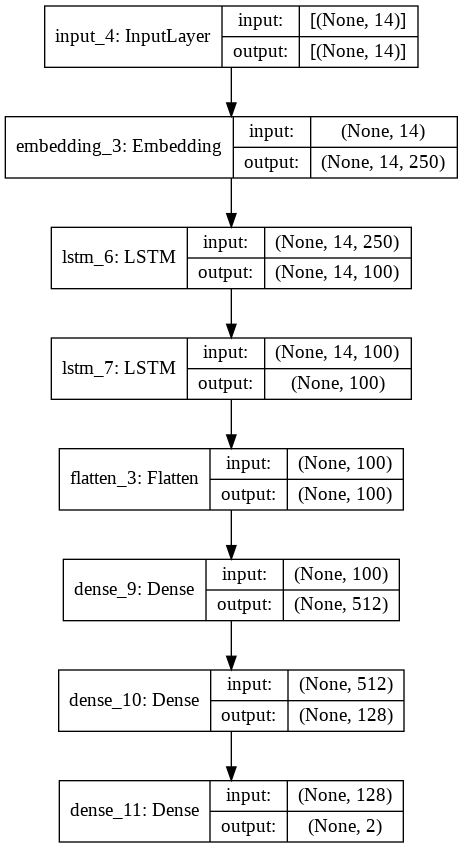

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(mod_lstm, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
a = mod_lstm.predict(x_padded)
a

array([[1.0477289e-08, 1.0000000e+00],
       [9.9991703e-01, 8.2983825e-05],
       [1.0000000e+00, 4.9365941e-08],
       ...,
       [1.0742191e-08, 1.0000000e+00],
       [1.0000000e+00, 3.1187039e-10],
       [1.0000000e+00, 1.1553084e-11]], dtype=float32)

In [ ]:
def get_proba_predict_deep_learning(dataFrame,model,tokenizer,minimal_kategori,maksimal_kategori,padding_type="post"):
  # menerima input dataframe yg berisi miss klasifikasi model deep learning
  # return dataframe yang memiliki proba dari predict model
  
  x_jadi = tokenizer.texts_to_sequences(dataFrame[0].values)
  
  x_jadi = pad_sequences(x_jadi,maxlen = max_length, padding = padding_type, truncating = truncating_type)
  temp = model.predict(x_jadi)

  for i in range(minimal_kategori,maksimal_kategori+1): 
    dataFrame[f'{i}'] = np.round(temp[:,i:i+1],4)
  return dataFrame
missProbaDL = get_proba_predict_deep_learning(missLstm,mod_lstm,tokenizer,0,1)
missProbaDL

,0,label,predict,0,1
0,iri orang orang punya rezeki nya untuk hidup...,0,1,0.0008,0.9992
1,pak bapak joko,1,0,1.0000,0.0000
2,engkau berbicara kualitas mu orang ikhlas meng...,0,1,0.0000,1.0000
3,kebaikan dilakukan jokowi terhitung jumlah nya...,0,1,0.0024,0.9976
4,tolakangkan benarbenar mempan menolak anginang...,0,1,0.0000,1.0000
5,keren baru,0,1,0.0021,0.9979
6,kasian anaknya anaknya rusak jugak kayak emakn...,0,1,0.0000,1.0000
7,film indonesia penonton nya marah kesal menan...,0,1,0.0602,0.9398
8,terkadang bingung menghina jokowi orang benci ...,0,1,0.0004,0.9996
9,sektor pariwisata menjadi andalan baru pembang...,0,1,0.0000,1.0000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


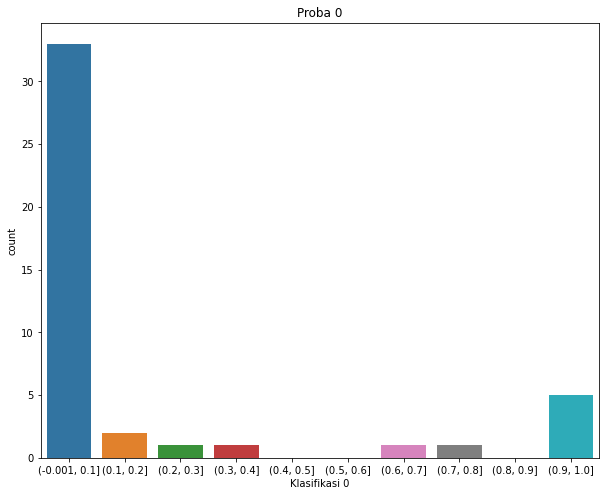

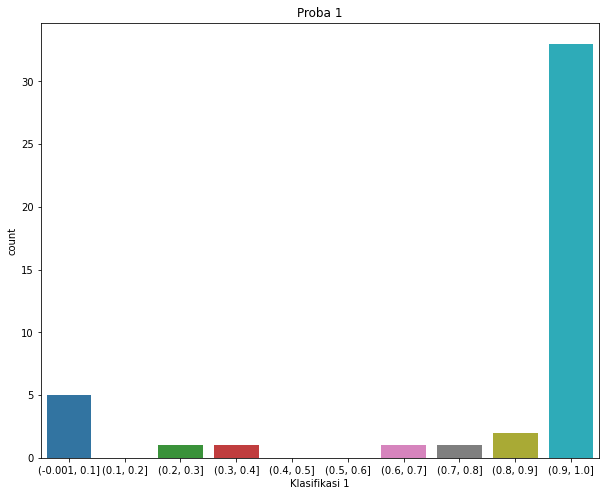

In [ ]:

def visProbaDF(missDL,minimal_kategori,maksimal_kategori):
  for i in range(minimal_kategori,maksimal_kategori+1):
    plt.figure()
    klasifikasi = i
    sns.countplot(pd.cut(missDL[f'{klasifikasi}'],bins=10))
    plt.title(f'Proba {klasifikasi}')
    plt.xlabel(f'Klasifikasi {klasifikasi}')
  plt.show()
visProbaDF(missProbaDL,0,1)

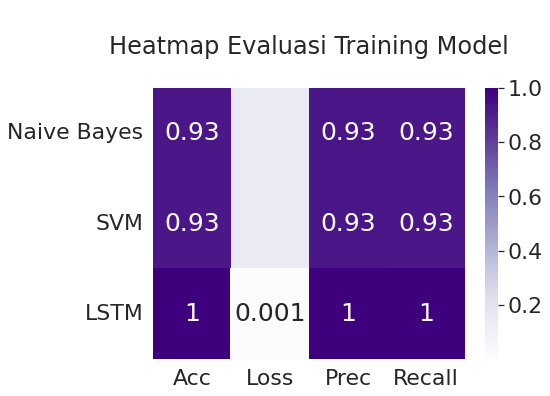

In [ ]:
# loss: 3.4264e-04 - TruePositive: 5928.0000 - FalsePositive: 0.0000e+00 - TrueNegative: 5928.0000 - FalseNegative: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.2196 - val_TruePositive: 1439.0000 - val_FalsePositive: 44.0000 - val_TrueNegative: 1439.0000 - val_FalseNegative: 44.0000 - val_accuracy: 0.9703 - val_precision: 0.9703 - val_recall: 0.9703 - val_auc: 0.9815

# svm
# result Mean train acc: 0.9267305148713214
# result Mean train precision: 0.9330239280319524
# result Mean train recall: 0.9267674903609906
# result Mean train f1: 0.9264639587818939
# result Mean valid acc: 0.9217378603935016
# result Mean valid precision: 0.9269932304850629
# result Mean valid recall: 0.9217864751708313
# result Mean valid f1: 0.9214261909695759


# naive
# result Mean train acc: 0.9267305148713214
# result Mean train precision: 0.9330239280319524
# result Mean train recall: 0.9267674903609906
# result Mean train f1: 0.9264639587818939
# result Mean valid acc: 0.9217378603935016
# result Mean valid precision: 0.9269932304850629
# result Mean valid recall: 0.9217864751708313
# result Mean valid f1: 0.9214261909695759

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=2.0)
plt.figure(figsize=(7,5))
data = np.array([[0.9267305148713214, np.nan, 0.9330239280319524, 0.9267674903609906],
                 [0.9267305148713214, np.nan, 0.9330239280319524, 0.9267674903609906],
                 [1.0000, 0.001, 1.0000, 1.0000]])
plt.title("\nHeatmap Evaluasi Training Model\n")
tempDF = pd.DataFrame(data, index = ['Naive Bayes', 'SVM', 'LSTM'], 
                  columns= ['Acc','Loss','Prec','Recall'])
sns.heatmap(tempDF,annot=True,cmap="Purples",annot_kws={'size': 25})

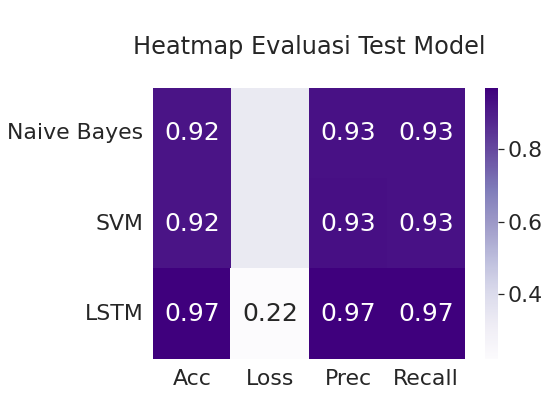

In [ ]:
# loss: 3.4264e-04 - TruePositive: 5928.0000 - FalsePositive: 0.0000e+00 - TrueNegative: 5928.0000 - FalseNegative: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.2196 - val_TruePositive: 1439.0000 - val_FalsePositive: 44.0000 - val_TrueNegative: 1439.0000 - val_FalseNegative: 44.0000 - val_accuracy: 0.9703 - val_precision: 0.9703 - val_recall: 0.9703 - val_auc: 0.9815

# svm
# result Mean train acc: 0.9267305148713214
# result Mean train precision: 0.9330239280319524
# result Mean train recall: 0.9267674903609906
# result Mean train f1: 0.9264639587818939
# result Mean valid acc: 0.9217378603935016
# result Mean valid precision: 0.9269932304850629
# result Mean valid recall: 0.9217864751708313
# result Mean valid f1: 0.9214261909695759


# naive
# result Mean train acc: 0.9267305148713214
# result Mean train precision: 0.9330239280319524
# result Mean train recall: 0.9267674903609906
# result Mean train f1: 0.9264639587818939
# result Mean valid acc: 0.9217378603935016
# result Mean valid precision: 0.9269932304850629
# result Mean valid recall: 0.9217864751708313
# result Mean valid f1: 0.9214261909695759

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=2.0)
plt.figure(figsize=(7,5))
data = np.array([[0.9217378603935016, np.nan, 0.9269932304850629, 0.9267674903609906],
                 [0.9217378603935016, np.nan, 0.9330239280319524, 0.9267674903609906],
                 [0.9703, 0.2196, 0.9703, 0.9703]])
plt.title("\nHeatmap Evaluasi Test Model\n")
tempDF = pd.DataFrame(data, index = ['Naive Bayes', 'SVM', 'LSTM'], 
                  columns= ['Acc','Loss','Prec','Recall'])
sns.heatmap(tempDF,annot=True,cmap="Purples",annot_kws={'size': 25})

# **Machine Learning**

In [ ]:
TF_obj = sklearn.feature_extraction.text.TfidfVectorizer(max_features = 250,)
def TF_idf(features_array,obj):
  features_array = np.array(features_array)
  mat = TF_obj.fit_transform(features_array)

  return mat.toarray(),TF_obj
Tf_data, TF_obj = TF_idf(df["tweet"].values,TF_obj)
Y = df["labels"].values

In [ ]:

### MOdelling SVC


def fastModelling(model, X, Y, title,TF_obj):
  """
  Fast modelling, TF_obj pakenya yang Global variable.

  model : Sklearn Model
  X : Input featuresa
  Y : Label
  TF_obj : TF_idf Object
  """
  x_train,x_test,y_train,y_test = sklearn.model_selection.train_test_split(X,Y,test_size=0.2,random_state=42)
  model = model.fit(x_train,y_train)

  print(f"Training Acc {model.score(x_train,y_train)}")
  print("")
  y_pred = model.predict(x_test)
  print(classification_report(y_test,y_pred))

  missclass = np.argwhere(np.not_equal(y_test,y_pred)).ravel()
  true_classified = np.argwhere(np.equal(y_test,y_pred).ravel())
  
  missclassDf = pd.DataFrame([" ".join(i) for i in TF_obj.inverse_transform(x_test[missclass])])
  missclassDf["label"] = y_test[missclass]
  missclassDf["predict"] = y_pred[missclass]
  
  true_classifiedDf = pd.DataFrame([" ".join(i) for i in TF_obj.inverse_transform(x_test[true_classified])])
  true_classifiedDf["label"] = y_test[true_classified]
  true_classifiedDf["predict"] = y_pred[true_classified]
  
  return model,true_classifiedDf,missclassDf,y_test,y_pred,
#svm_model, true_classified,missclassDf,y_test,y_pred = fastModelling(svm_model, Tf_data, Y, "test", TF_obj)


In [ ]:
def fastFold(model, X, Y, num_split,method="kfold"):

  """
  Fast Kfold
  
  """
  obj = object
  if (method.lower() =="kfold"):
    obj = KFold(num_split)
  else:
    obj = StratifiedKFold(num_split)
  
  rate_acc_train = []
  rate_acc_test = []    
    
  rate_precision_train = []
  rate_precision_test = []
    
  rate_recall_train = []
  rate_recall_test = []
    
  rate_f1_train = []
  rate_f1_test = []
  
  fold = 1
  
  for train_indx,val_indx in obj.split(X,Y):
    print(f"Training At Fold {fold} ")
    x_train = X[train_indx]
    y_train = Y[train_indx]

    x_val = X[val_indx] 
    y_val = Y[val_indx]
    
    model.fit(x_train,y_train)
        
    train_score_acc = model.score(x_train,y_train)
    test_score_acc = model.score(x_val,y_val)
        
    train_pred = model.predict(x_train)
    test_pred = model.predict(x_val)
        
    train_precision,train_recall,train_f1,_ = precision_recall_fscore_support(y_train,train_pred,average="macro")
        
    test_precision,test_recall,test_f1,_ = precision_recall_fscore_support(y_val,test_pred,average="macro")        
        
    rate_acc_train.append(train_score_acc)
    rate_acc_test.append(test_score_acc)
        
    rate_precision_train.append(train_precision)
    rate_precision_test.append(test_precision)
        
    rate_recall_train.append(train_recall)
    rate_recall_test.append(test_recall)
        
    rate_f1_train.append(train_f1)
    rate_f1_test.append(test_f1)

    print("=======================================================")
    print(f"AT fold {fold} Training Acc : {train_score_acc}")
    print(f"AT fold {fold} Training Precision : {train_precision}")
    print(f"AT fold {fold} Training Recall : {train_recall}")
    print(f"AT fold {fold} Training F1_score : {train_f1}")
    print("=======================================================")
    print(f"AT fold {fold} Validation Acc : {train_score_acc}")
    print(f"AT fold {fold} Validation Precision : {train_precision}")
    print(f"AT fold {fold} Validation Recall : {train_recall}")
    print(f"AT fold {fold} Validation F1_score : {train_f1}")
    print("=======================================================\n\n")        
    fold += 1
    
  result =  [rate_acc_train,rate_precision_train,rate_recall_train,rate_f1_train,
            rate_acc_test,rate_precision_test,rate_recall_test,rate_f1_test]
  print(f'result Mean train acc: {np.mean(result[0])}')
  print(f'result Mean train precision: {np.mean(result[1])}')
  print(f'result Mean train recall: {np.mean(result[2])}')
  print(f'result Mean train f1: {np.mean(result[3])}')

  print(f'result Mean valid acc: {np.mean(result[4])}')
  print(f'result Mean valid precision: {np.mean(result[5])}')
  print(f'result Mean valid recall: {np.mean(result[6])}')
  print(f'result Mean valid f1: {np.mean(result[7])}')
  return result

In [ ]:
svm_model_awal = SVC(C=1.0,gamma=1.0)
naive_awal = GaussianNB()

In [ ]:
Naive_result_fold = fastFold(svm_model_awal,Tf_data,Y,5)

Training At Fold 1 
AT fold 1 Training Acc : 0.9723346828609987
AT fold 1 Training Precision : 0.9729510214127493
AT fold 1 Training Recall : 0.9724809136496034
AT fold 1 Training F1_score : 0.9723303711426564
AT fold 1 Validation Acc : 0.9723346828609987
AT fold 1 Validation Precision : 0.9729510214127493
AT fold 1 Validation Recall : 0.9724809136496034
AT fold 1 Validation F1_score : 0.9723303711426564


Training At Fold 2 
AT fold 2 Training Acc : 0.9701467363805026
AT fold 2 Training Precision : 0.9707080730400006
AT fold 2 Training Recall : 0.9702562166347253
AT fold 2 Training F1_score : 0.9701418303813967
AT fold 2 Validation Acc : 0.9701467363805026
AT fold 2 Validation Precision : 0.9707080730400006
AT fold 2 Validation Recall : 0.9702562166347253
AT fold 2 Validation F1_score : 0.9701418303813967


Training At Fold 3 
AT fold 3 Training Acc : 0.9716646989374262
AT fold 3 Training Precision : 0.9725554039279529
AT fold 3 Training Recall : 0.9716537680163692
AT fold 3 Training 

In [ ]:
svm_model, true_classified,miss_svm,y_test,y_pred = fastModelling(svm_model_awal, Tf_data, Y, "test", TF_obj)

Training Acc 0.9719973009446694

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       732
           1       0.94      0.98      0.96       751

    accuracy                           0.96      1483
   macro avg       0.96      0.96      0.96      1483
weighted avg       0.96      0.96      0.96      1483



In [ ]:
Naive_result_fold = fastFold(naive_awal,Tf_data,Y,5)

Training At Fold 1 
AT fold 1 Training Acc : 0.9261133603238867
AT fold 1 Training Precision : 0.9322970093900418
AT fold 1 Training Recall : 0.9265650761792057
AT fold 1 Training F1_score : 0.9258974284039081
AT fold 1 Validation Acc : 0.9261133603238867
AT fold 1 Validation Precision : 0.9322970093900418
AT fold 1 Validation Recall : 0.9265650761792057
AT fold 1 Validation F1_score : 0.9258974284039081


Training At Fold 2 
AT fold 2 Training Acc : 0.9259571597233935
AT fold 2 Training Precision : 0.9319604519774012
AT fold 2 Training Recall : 0.9263100375809887
AT fold 2 Training F1_score : 0.9257381240973979
AT fold 2 Validation Acc : 0.9259571597233935
AT fold 2 Validation Precision : 0.9319604519774012
AT fold 2 Validation Recall : 0.9263100375809887
AT fold 2 Validation F1_score : 0.9257381240973979


Training At Fold 3 
AT fold 3 Training Acc : 0.9266318097486929
AT fold 3 Training Precision : 0.9327903663915758
AT fold 3 Training Recall : 0.9266016655405428
AT fold 3 Training 

In [ ]:
naive_model, true_classified,miss_naive,y_test,y_pred = fastModelling(naive_awal, Tf_data, Y, "test", TF_obj)

Training Acc 0.9257759784075573

              precision    recall  f1-score   support

           0       0.98      0.87      0.92       732
           1       0.89      0.98      0.93       751

    accuracy                           0.93      1483
   macro avg       0.93      0.93      0.93      1483
weighted avg       0.93      0.93      0.93      1483



## **validasi**

In [ ]:
validasi = pd.read_csv('https://raw.githubusercontent.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/master/dataset_komentar_instagram_cyberbullying.csv')

In [ ]:
validasi['Sentiment'] = validasi['Sentiment'].replace({'negative':1,'positive':0})
validasi

,Id,Sentiment,Instagram Comment Text
0,1,1,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,2,1,Geblek lo tata...cowo bgt dibela2in balikan......
2,3,1,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,4,1,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,5,1,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."
...,...,...,...
395,396,0,Bangga sama suami yg selalu ingat istri disela...
396,397,0,Apaoun pekerjaannya yg penting halal u tuk men...
397,398,0,Gojek itu mayoritas pegangguran yang lama gak ...
398,399,0,<USERNAME> aslinya cantik dan ayu loh mbak kr...


In [ ]:
validasi = preprocessing(validasi,'Instagram Comment Text')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to b

In [ ]:
x_val = TF_obj.transform(validasi['Instagram Comment Text'].values).toarray()

In [ ]:
x_val

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
y_predict_val = svm_model.predict(x_val)
print(classification_report(validasi['Sentiment'].values,y_predict_val))

              precision    recall  f1-score   support

           0       0.98      0.67      0.80       200
           1       0.75      0.98      0.85       196

    accuracy                           0.83       396
   macro avg       0.86      0.83      0.82       396
weighted avg       0.86      0.83      0.82       396



In [ ]:


x_sequences = tokenizer.texts_to_sequences(validasi['Instagram Comment Text'].values)
x_val_lstm = pad_sequences(x_sequences,maxlen = max_length, padding = padding_type, truncating = truncating_type)
y_val_lstm = to_categorical(validasi['Sentiment'])
mod_lstm.evaluate(x_val_lstm, y_val_lstm, batch_size=64)

7/7 [==============================] - 0s 6ms/step - loss: 0.2021 - TruePositive: 386.0000 - FalsePositive: 10.0000 - TrueNegative: 386.0000 - FalseNegative: 10.0000 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9835    


[0.20211368799209595,
 386.0,
 10.0,
 386.0,
 10.0,
 0.9747474789619446,
 0.9747474789619446,
 0.9747474789619446,
 0.9834710359573364]

# Error Analysis

In [ ]:
from wordcloud import WordCloud, ImageColorGenerator
from nltk.probability import FreqDist
def wordCloud(df,column,title):
  mostCommonOne = FreqDist(splitWord(df,column)).most_common(300)
  wordcloud = WordCloud(width=800,height=400,background_color='white').generate(str(mostCommonOne))
  fig = plt.figure(figsize=(15,10),facecolor='white')
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f"{title}", fontsize=50)

  plt.tight_layout(pad=0)
  plt.show()
def splitWord(data,column):
  data = data.reset_index()
  l_tmp = []
  for i in range (0, len(data)):
    l_tmp.append(data[column][i].split())
  l_word = []
  for wordlist in l_tmp:
    l_word += wordlist
  return l_word

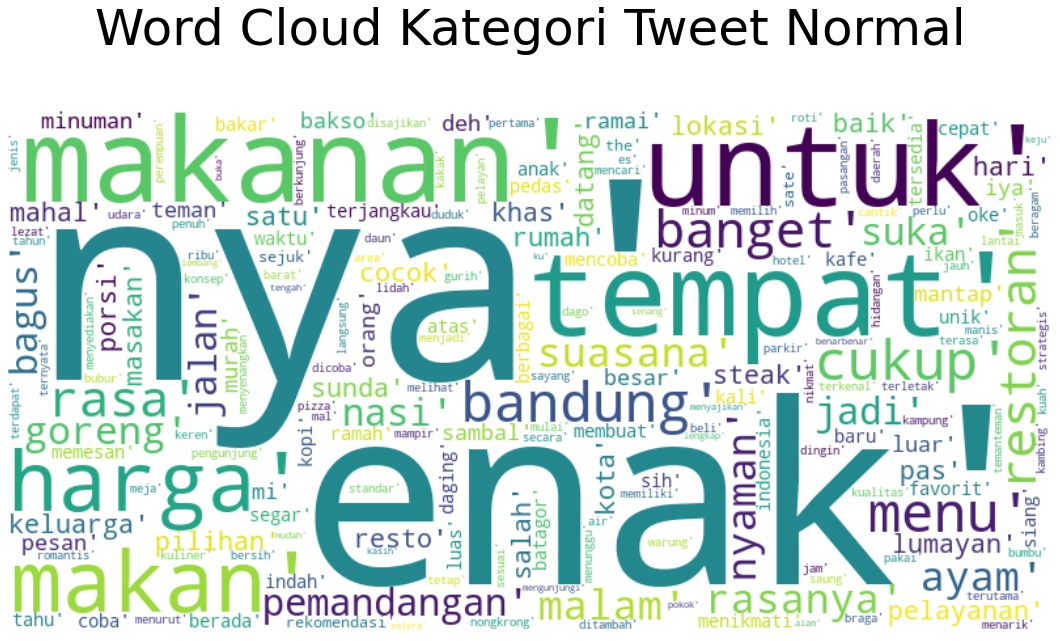

In [ ]:
wordCloud(df[df['labels']==0],'tweet','Word Cloud Kategori Tweet Normal\n')

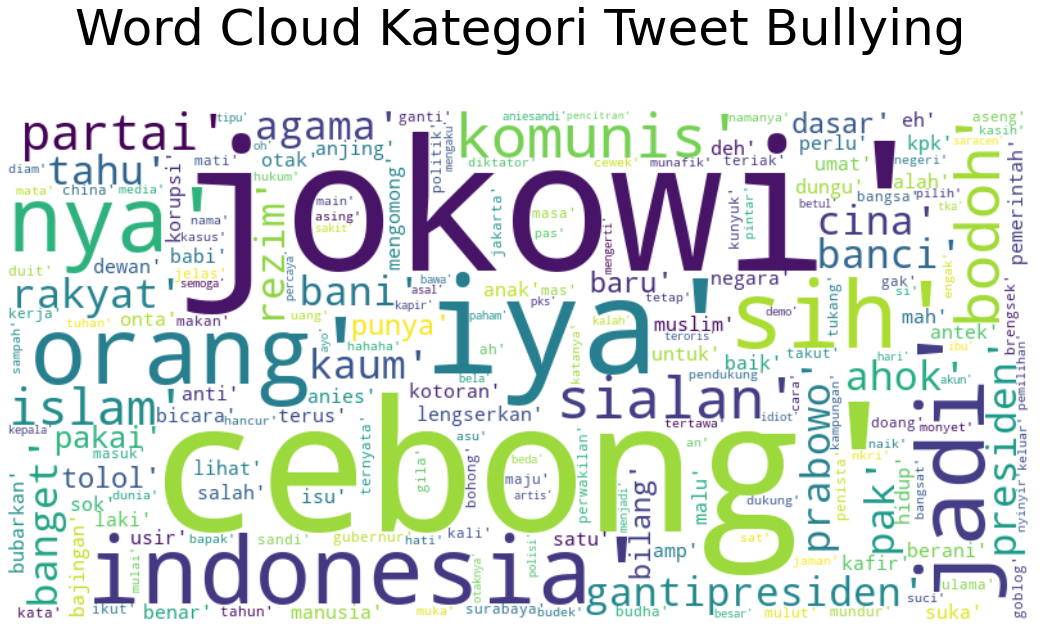

In [ ]:
wordCloud(df[df['labels']==1],'tweet','Word Cloud Kategori Tweet Bullying\n')

1 persentase miss --> 0.002 Dari Total Data 3707, 7 Misklasifikasi
2 persentase miss --> 0.01 Dari Total Data 3704, 37 Misklasifikasi


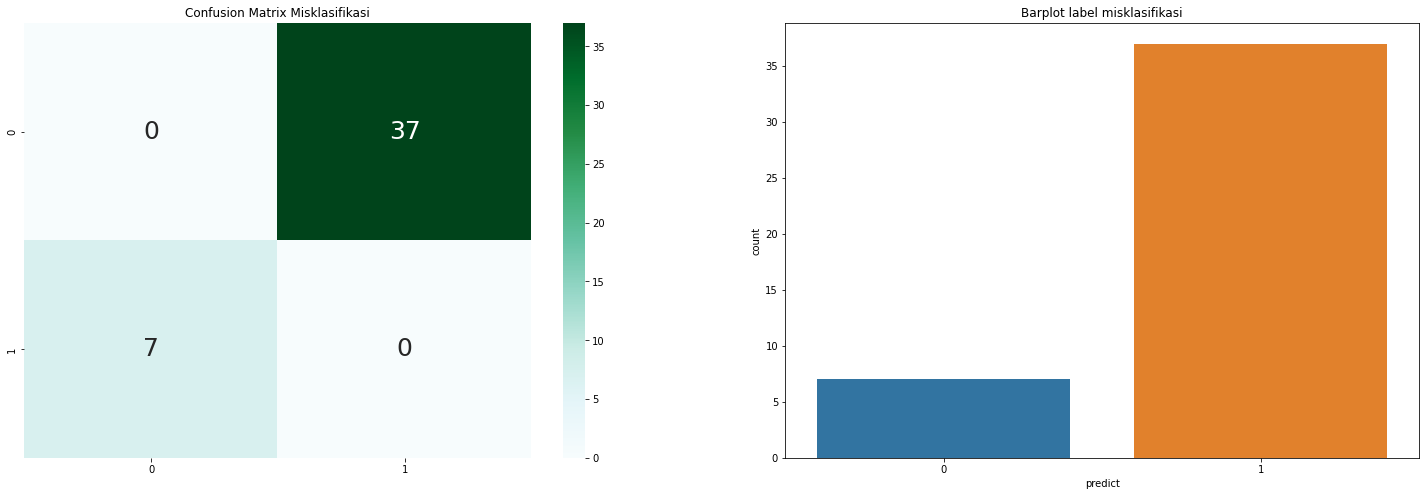

In [ ]:
def identifyMissclass(df,missclassDf,title,indexColumns=[],columns=[]):
  """
  Fungsi akan mengidentifikasi missclass, dengan melakukan count dan analisis secara umum,
  terkait permasalahan hasil klasifikasi
  """

  if indexColumns != [] and columns != []:

    conf = confusion_matrix(missclassDf["label"],missclassDf["predict"])
    dfConf = pd.DataFrame(conf,index=indexColumns,
                          columns = columns)
    f,(ax1,ax2) = plt.subplots(1,2,figsize=(25,8))
    ax1.set_title("Confusion Matrix Misklasifikasi")
    sns.heatmap(dfConf,annot=True,cmap="BuGn",annot_kws={"size":25},ax=ax1)
    
    ax2.set_title("Barplot label misklasifikasi")
    sns.countplot(data=missclassDf,x="predict",ax=ax2)
    
    count_the_label = df["label"].value_counts().values
    count_miss_class_label_row = dfConf.sum(axis=0)
    #count_miss_class_label_col = dfConf.sum(axis=1)
    count_miss_class_label = count_miss_class_label_row 
    persentase_miss = np.round((count_miss_class_label / count_the_label).values ,3)

    for i in range(len(indexColumns)):
      print(f"{i + 1} persentase miss --> {persentase_miss[i]} Dari Total Data {count_the_label[i]}, { int(float(count_the_label[i]) * float(persentase_miss[i])) } Misklasifikasi")

  else:
    indexColumns = missclassDf["predict"].value_counts().index
    conf = confusion_matrix(missclassDf["label"],missclassDf["predict"])
    dfConf = pd.DataFrame(conf,index=[0,1],
                          columns = [0,1])
    f,(ax1,ax2) = plt.subplots(1,2,figsize=(25,8))
    ax1.set_title("Confusion Matrix Misklasifikasi")
    sns.heatmap(dfConf,annot=True,cmap="BuGn",annot_kws={"size":25},ax=ax1)
    
    ax2.set_title("Barplot label misklasifikasi")
    sns.countplot(data=missclassDf,x="predict",ax=ax2)
    
    count_the_label = df["labels"].value_counts().values
    count_miss_class_label_row = dfConf.sum(axis=0)
    #count_miss_class_label_col = dfConf.sum(axis=1)
    count_miss_class_label = count_miss_class_label_row 
    persentase_miss = np.round((count_miss_class_label / count_the_label).values ,3)

    for i in range(len(indexColumns)):
      print(f"{i + 1} persentase miss --> {persentase_miss[i]} Dari Total Data {count_the_label[i]}, { int(float(count_the_label[i]) * float(persentase_miss[i])) } Misklasifikasi")

identifyMissclass(df,missLstm,"tetew")

1 persentase miss --> 0.004 Dari Total Data 3707, 14 Misklasifikasi
2 persentase miss --> 0.014 Dari Total Data 3704, 51 Misklasifikasi


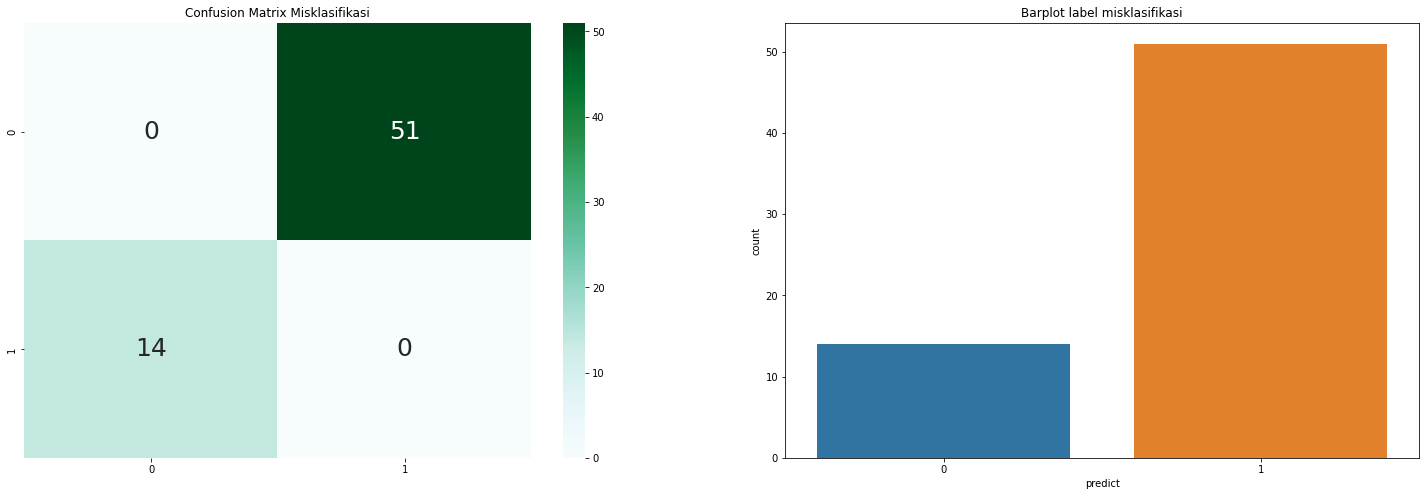

In [ ]:
identifyMissclass(df,miss_svm,"tetew")

1 persentase miss --> 0.004 Dari Total Data 3707, 14 Misklasifikasi
2 persentase miss --> 0.026 Dari Total Data 3704, 96 Misklasifikasi


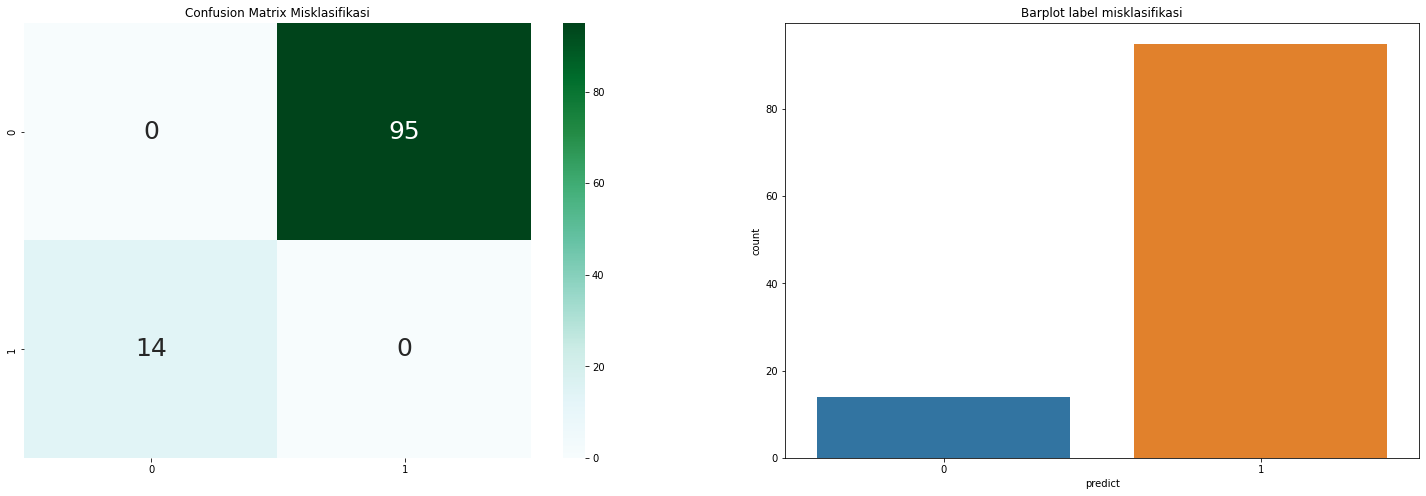

In [ ]:
identifyMissclass(df,miss_naive,"tetew")

In [ ]:
def printMissClass(missclassDf,title,columnPredict,columnTrue):
  """
  Fungsi akan menampilkan teks missclass, untuk masing masing kelas 
  """

  unique_class = missclassDf[columnPredict].unique()
  
  teks = []
  for i in unique_class:
    teks.append( (i, missclassDf.loc[missclassDf[columnPredict] == i,0].values,
                  missclassDf.loc[missclassDf[columnPredict] == i,columnTrue].values))

  for i in range(len(unique_class)):
    print("========================================================")
    print(f"THIS IS SECTION FOR missclassPredicted {teks[i][0]}")
    max_length = 0
    min_length = 100
    for indx, kalimat in enumerate(teks[i][1]):
        print("True Label = " ,teks[i][2][indx], " ", teks[i][0] , "-- > ", kalimat,"<--- Predicted as = ",end="\n")
        total_kata = len(str(kalimat).split())
        if(total_kata < min_length):
          min_length = total_kata
        if(total_kata > max_length):
          max_length = total_kata

    print("=============================== miscellaneous =====================")
    print(f"Max Length : {max_length}")
    print(f"Min Length : {min_length}")    
    
    
    print("========================================================")
printMissClass(missLstm,"tw","predict","label")

THIS IS SECTION FOR missclassPredicted 1
True Label =  0   1 -- >  iri orang  orang punya rezeki nya  untuk hidup     <--- Predicted as = 
True Label =  0   1 -- >  engkau berbicara kualitas mu orang ikhlas menghargai kehebatan mu      <--- Predicted as = 
True Label =  0   1 -- >  kebaikan dilakukan jokowi terhitung jumlah nya         <--- Predicted as = 
True Label =  0   1 -- >  tolakangkan benarbenar mempan menolak anginangin jahat mantips        <--- Predicted as = 
True Label =  0   1 -- >  keren  baru            <--- Predicted as = 
True Label =  0   1 -- >  kasian anaknya anaknya rusak jugak kayak emaknya ya       <--- Predicted as = 
True Label =  0   1 -- >  film indonesia penonton nya  marah kesal menangis ketawa tobat pokok nya jadi satu <--- Predicted as = 
True Label =  0   1 -- >  terkadang bingung menghina jokowi orang benci beliau jelas bingung atas dasar jokowi bekerja untuk <--- Predicted as = 
True Label =  0   1 -- >  sektor pariwisata menjadi andalan baru pembangu

# **Saving**